<center>
<h1>MetPy's Integration with XArray: What's been done, and what remains
<br>
<h3>14 August 2018
<br>
<br>
Ryan May (@dopplershift)
<br><br>
UCAR/Unidata
</h3>
</center>

In [3]:
%matplotlib inline
from datetime import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore

/Users/rmay/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## What is MetPy?
* Python toolkit for meteorology
* File format support: NEXRAD, GINI, etc.
* Calculations (with physical units):
   - Kinematics
   - Interpolation (e.g. isentropic)
   - Thermodynamics
   - Indices
   - etc.
* Plotting
   - Station Plots
   - Skew T's
* Its mission in life is to ~~kill~~ gracefully replace GEMPAK

<img src="sphx_glr_Advanced_Sounding_001.png" style="width:800px"/>

![](sphx_glr_cross_section_001.png)

So trying to replace:
![Trenberth Example](./us-trenberth.gif)

With:
![weather map](./weather-map.png)

* MetPy needs a data model for gridded data
* Started using netCDF4-python
* And adding stuff

* This is pretty much XArray, so let's use it!

## Problem 1: Projections
* Assuming we have netCDF data, gridded coordinate systems store as a bundle of attributes
* GOOD: Data are self-describing
* BAD: Users have to convert these attributes into API calls (terrible for teaching)
* Also, doing this generically is hard

In [15]:
goes_cat = TDSCatalog('http://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/'
                      'GOES16/CONUS/Channel14/current/catalog.xml')w
satdata = xr.open_dataset(goes_cat.datasets[-1].access_urls['OPENDAP'])
proj_info = satdata.fixedgrid_projection
proj_info

<xarray.DataArray 'fixedgrid_projection' ()>
array(-2147483647, dtype=int32)
Coordinates:
    time     datetime64[ns] ...
Attributes:
    grid_mapping_name:               geostationary
    latitude_of_projection_origin:   0.0
    longitude_of_projection_origin:  -75.00000000000001
    semi_major:                      6378137.0
    semi_major_axis:                 6378137.0
    semi_minor:                      6356752.31414
    semi_minor_axis:                 6356752.31414
    perspective_point_height:        35785831.0
    sweep_angle_axis:                x

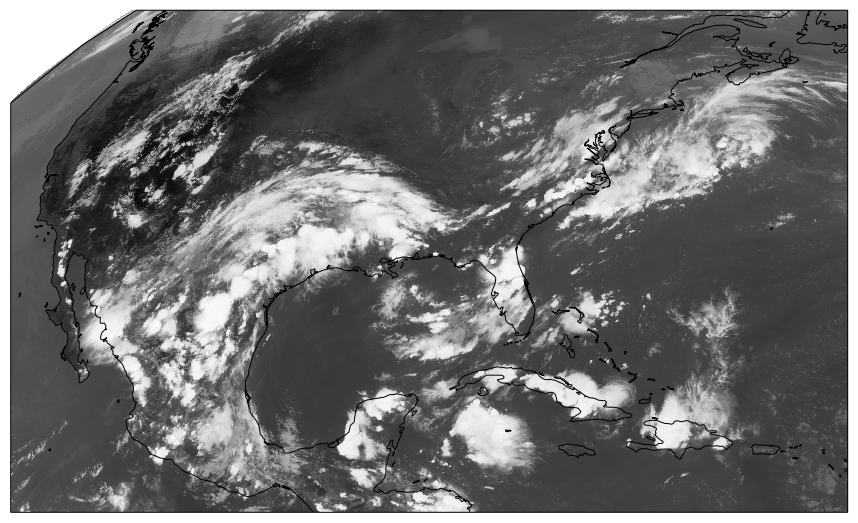

In [12]:
fig = plt.figure(figsize=(15, 10))
globe = ccrs.Globe(semimajor_axis=proj_info.semi_major_axis,
                   semiminor_axis=proj_info.semi_minor_axis)
proj = ccrs.Geostationary(central_longitude=proj_info.longitude_of_projection_origin,
                          satellite_height=proj_info.perspective_point_height,
                          globe=globe, sweep_axis=proj_info.sweep_angle_axis)
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.coastlines(resolution='50m')
x = satdata.x * proj_info.perspective_point_height / 1e6 
y = satdata.y * proj_info.perspective_point_height / 1e6
ax.imshow(satdata.Sectorized_CMI, cmap='Greys', origin='upper',
          extent=(x.min(), x.max(), y.min(), y.max()))

## Solution
* MetPy custom accessor on `Dataset` and `DataArray`
* Registry of code to generate CartoPy projections from CF-compliant Metadata
* By hooking into `Dataset`, we can properly walk the metadata

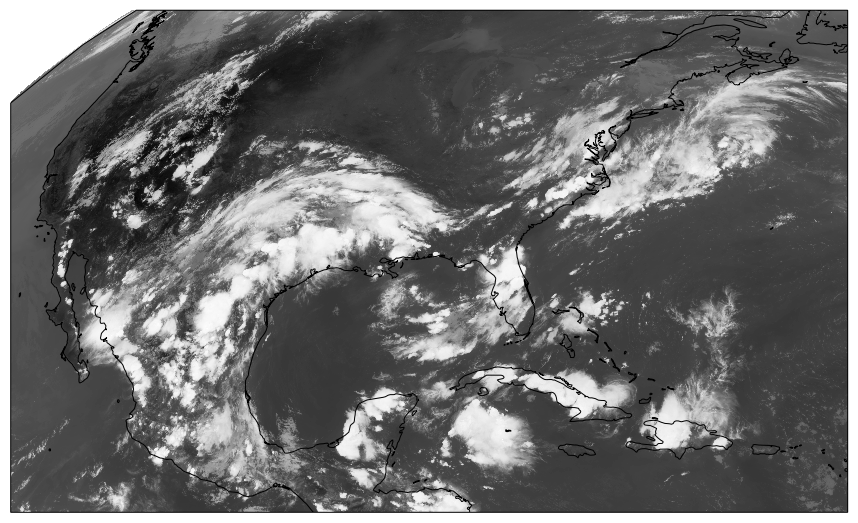

In [16]:
fig = plt.figure(figsize=(15, 10))
data = satdata.metpy.parse_cf('Sectorized_CMI')
ax = fig.add_subplot(1, 1, 1, projection=data.metpy.cartopy_crs)
ax.coastlines(resolution='50m')
ax.imshow(satdata.Sectorized_CMI, cmap='Greys', origin='upper',
          extent=(data.x.min(), data.x.max(),
                  data.y.min(), data.y.max()))

## Problem 2: Units and Calculations
* MetPy's calculations are unit-aware, using pint
* pint independently wraps NumPy arrays
* pint + XArray -> Boom!

## Solution (sort of)
* Add `unit_array` attribute to MetPy accessor
  - Automatically generate pint-wrapped array from XArray `DataArray` and `units` attribute
  - Provides hook to adjust units as needed
  - Can also convert `DataArray` in-place
* Decorate MetPy calculation functions
  - Check for `DataArray`s passed in and convert
  - Makes calculations "just work"
  - Does **NOT** return `DataArray`

In [4]:
gfs_cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/'
                     'grib/NCEP/GFS/Global_0p5deg/catalog.xml')
gfs_data = xr.open_dataset(gfs_cat.latest.access_urls['OPENDAP'])
gfs_data.Relative_humidity_isobaric.attrs['units'] = 'percent'
dewpt = mpcalc.dewpoint_rh(
    gfs_data.Temperature_isobaric.sel(isobaric=50000),
    gfs_data.Relative_humidity_isobaric.sel(isobaric=50000))

/Users/rmay/repos/metpy/metpy/calc/thermo.py:619: RuntimeWarning: overflow encountered in exp
  (temperature - 29.65 * units.kelvin))
/Users/rmay/miniconda3/envs/py36/lib/python3.6/site-packages/pint/quantity.py:1403: RuntimeWarning: overflow encountered in exp
  out = uf(*mobjs)
/Users/rmay/miniconda3/envs/py36/lib/python3.6/site-packages/pint/quantity.py:802: RuntimeWarning: invalid value encountered in multiply
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


* Good interim step
* Allows starting to use XArray easily (we still need to make releases)
* Half of the desired behavior

# Problem 3: Dimension Names

* THREDDS Data Server provides nice collections on top of GRIB files
* Nature of GRIB makes this...challenging to deal with:

In [32]:
gfs_data = xr.open_dataset(gfs_cat.datasets[1].access_urls['OPENDAP'])
print([d for d in gfs_data.dims if 'isobaric' in d])

['isobaric', 'isobaric1', 'isobaric2', 'isobaric3', 'isobaric4', 'isobaric5']


In [41]:
heights = gfs_data.metpy.parse_cf('Absolute_vorticity_isobaric')
heights.dims

('time', 'isobaric4', 'lat', 'lon')

## Solution: Interpret CF metadata

In [44]:
heights.metpy.vertical

<xarray.DataArray 'isobaric4' (isobaric4: 26)>
array([  1000.,   2000.,   3000.,   5000.,   7000.,  10000.,  15000.,  20000.,
        25000.,  30000.,  35000.,  40000.,  45000.,  50000.,  55000.,  60000.,
        65000.,  70000.,  75000.,  80000.,  85000.,  90000.,  92500.,  95000.,
        97500., 100000.], dtype=float32)
Coordinates:
  * isobaric4  (isobaric4) float32 1000.0 2000.0 3000.0 5000.0 7000.0 ...
    crs        object Projection: latitude_longitude
Attributes:
    units:                   Pa
    long_name:               Isobaric surface
    positive:                down
    Grib_level_type:         100
    _CoordinateAxisType:     Pressure
    _CoordinateZisPositive:  down
    axis:                    Z

* Will be released later this month in 0.9
* Still kicking the tires on this to see if this is a good API
* Used to power our cross-section support

## Future work
* So far using XArray is good

* Except when it's not

## More Problems: XArray hates TDS

### Full Collection

In [51]:
try:
    xr.open_dataset(gfs_cat.datasets[0].access_urls['OPENDAP'])
except Exception as e:
    print(e)

'time' has more than 1-dimension and the same name as one of its dimensions ('reftime', 'time'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.


### NetCDF Subset Service
* TDS can subset a grid--this works well
* TDS can also return point data (e.g. timeseries) from the grid--this works...not at all

In [11]:
try:
    ncss = gfs_cat.latest.subset()
    query = ncss.query().variables('Geopotential_height_isobaric')
    query.time(datetime.utcnow()).lonlat_point(lon=-105, lat=40)
    query.add_lonlat().accept('netcdf4')
    nc = ncss.get_data(query)
    xr.open_dataset(NetCDF4DataStore(nc))
except Exception as e:
    print(str(e))

'isobaric' has more than 1-dimension and the same name as one of its dimensions ('station', 'profile', 'isobaric'). xarray disallows such variables because they conflict with the coordinates used to label dimensions.


## Units

![Head Smash](./perry-headsmash.gif)

![Tire Fire](./good-tire-fire.gif)

* Making multiple numpy array subclasses (or array-like) play together is ~~impossible~~ really hard
* There's movement in the community...but it's slow
* I had been focused on getting XArray to wrap a pint array...
* I think the best approach are hooks in XArray, maybe in `__array_ufunc__`
* Tightly coupled into XArray...maybe using cf_units/udunits?
* Any other thoughts?

In [64]:
%matplotlib inline
from datetime import datetime
from traitlets import HasTraits, Unicode, Tuple, Int, List, Any, Union, Instance, Float, default, observe, link
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib.pyplot as plt
import numpy as np
from metpy.cbook import is_string_like
from metpy.plots import ctables

proj_lookup = dict(lcc=ccrs.LambertConformal(central_latitude=40, central_longitude=-100,
                                             standard_parallels=[30, 60]))
garea_lookup = dict(us=(-115, -65, 25, 50))

class Map(HasTraits):
    garea = Unicode()
    proj = Union([Unicode(), Instance(ccrs.Projection)])
    plots = List(Any())
    figsize = Tuple(Int(), Int())
    layout = Tuple(Int(), Int())
    
    @default('layout')
    def default_layout(self):
        return (1, 1)

    @observe('plots')
    def _plots_changed(self, change):
        if hasattr(self, 'fig'):
            delattr(self, 'fig')
        for plot in change.new:
            plot.observe(self.refresh)

    def refresh(self, _):
        self.draw()
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
    def draw(self):
        if not hasattr(self, 'fig'):
            self.fig = plt.figure(figsize=self.figsize)
            if is_string_like(self.proj):
                if self.proj == 'data':
                    proj = self.plots[0].griddata.metpy.cartopy_crs
                else:
                    proj = proj_lookup[self.proj]
            else:
                proj = self.proj
            nrow, ncol = self.layout
            self.ax = self.fig.add_subplot(nrow, ncol, 1, projection=proj)
        else:
            self.ax.cla()

        for p in self.plots:
            p.draw(self.ax)        

        self.ax.coastlines('50m', zorder=20)
        self.ax.add_feature(cfeat.STATES, zorder=20)

        if self.garea:
            if self.garea == 'global':
                self.ax.set_global()
            else:
                self.ax.set_extent(garea_lookup[self.garea], ccrs.PlateCarree())
        
        self.ax.set_title(', '.join(plot.name for plot in self.plots))
        return self.fig

    def __getitem__(self, ind):
        # TODO: Return particular axes
        pass

class Plot(HasTraits):
#    data = Any()
#    data = Instance(xr.Dataset)
    gfunc = Unicode()
    glevel = Int(allow_none=True, default_value=None)
    data_time = Instance(datetime, allow_none=True)

    @observe('gfunc')
    def _update_data(self, changed):
        self._griddata = self.data.metpy.parse_cf(changed.new)

    @property
    def griddata(self):
        return self._griddata

    @property
    def plotdata(self):
        subset = {'method': 'nearest'}
        if self.glevel is not None:
            subset[self.griddata.metpy.vertical.name] = self.glevel

        if self.data_time is not None:
            subset[self.griddata.metpy.time.name] = self.data_time

        imdata = self.griddata.sel(**subset)
        
        x = self.griddata.metpy.x
        y = self.griddata.metpy.y
        if 'degree' in x.units:
            X, Y = np.meshgrid(x, y)
            x, y, _ = self.griddata.metpy.cartopy_crs.transform_points(ccrs.PlateCarree(), X, Y).T
            x = x[:, 0] % 360
            y = y[0, :]
        
        return x, y, imdata

    @property
    def name(self):
        ret = self.gfunc
        if self.glevel is not None:
            ret += '@{:d}'.format(self.glevel)
        return ret
    
    @property
    def code(self):
        pass

class ImagePlot(Plot):
    ctable = Unicode()
    img_range = Tuple(Int(allow_none=True), Int(allow_none=True))

    @default('img_range')
    def default_img_range(self):
        return None, None

    def draw(self, ax):
        x, y, imdata = self.plotdata

        extents = (x.min(), x.max(), y.min(), y.max())
        origin = 'upper' if y[0] > y[-1] else 'lower'

        try:
            cmap = ctables.registry.get_colortable(self.ctable)
        except KeyError:
            cmap = plt.get_cmap(self.ctable)

        norm = plt.Normalize(*self.img_range)
        im = ax.imshow(imdata, extent=extents, origin=origin, cmap=cmap, norm=norm,
                       transform=self.griddata.metpy.cartopy_crs)
        #ax.figure.colorbar(im)

        
class ContourPlot(Plot):
    ctable = Unicode()
    img_range = Tuple(Int(allow_none=True), Int(allow_none=True))
    linecolor = Unicode('black')
    contours = Int(25)

    @default('img_range')
    def default_img_range(self):
        return None, None

    def draw(self, ax):
        x, y, imdata = self.plotdata
        im = ax.contour(x, y, imdata, self.contours, transform=self.griddata.metpy.cartopy_crs,
                        colors=self.linecolor, linewidths=2)

## What's the end goal?
* More of a declarative plotting interface

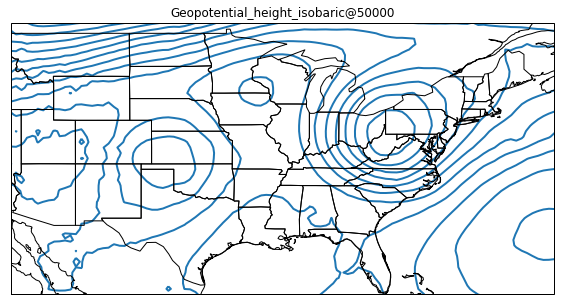

In [67]:
m = Map()
m.garea = 'us'
m.proj = 'data'
m.figsize = (10, 5)

cntr = ContourPlot()
cntr.data = gfs_data
cntr.gfunc = 'Geopotential_height_isobaric'
cntr.glevel = 50000
cntr.linecolor = 'tab:blue'
cntr.contours = 100
cntr.data_time = datetime.utcnow()

m.plots = [cntr]
m.draw();